In [1]:
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from astropy.visualization import make_lupton_rgb

from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
import lsst.source.injection as si
import numpy as np
import astropy.units as u
import pandas as pd

In [2]:
def make_one_plot(objects, title, data, Q, stretch, minimum, ax=None):
    if ax==None:
        fig, ax = plt.subplots(figsize=(4,4), dpi=175)
    
    rgb = make_lupton_rgb(objects[2], objects[1], objects[0], Q=Q, stretch=stretch, minimum=minimum)
    ax.imshow(rgb, aspect='equal')
    ax.set_xticks([], [])
    ax.set_yticks([], []) 
    #plt.savefig(png_path + title, bbox_inches='tight')

In [3]:
def get_color_image_and_cat(collection, registry):
        data_dict={}
        img_refs=sorted(registry.queryDatasets('injected_deepCoadd', collections=collection))
        obj_table_refs=sorted(registry.queryDatasets('injected_objectTable', collections=collection))
        refs_inj_cat=sorted(registry.queryDatasets('injection_catalog', collections=collection))
        for ref in img_refs:
            band=ref.dataId['band']
            img= butler.get(ref)
            data_dict[band + "_img"]=img.image[12600:13200, 700:1300].array
            
        object_table=[]
        for ref in obj_table_refs:
            
            data_dict["object_table"]=butler.get(ref)

        refcat=[]
        for ref in refs_inj_cat:
            if ref.dataId['band'] == 'g':
                refcat.append(butler.get(ref).to_pandas())
        data_dict["injection_cat"]=pd.concat(refcat)
        return data_dict
        

In [4]:
repo="/repo/main"
collection='u/pferguso/full_dwarf_test/2_lim_32/step3'
butler = Butler(repo, collections=collection)
registry = butler.registry

In [6]:
refs=sorted(registry.queryDatasets('injected_deepCoadd'))

In [7]:
refs=[refs[1],refs[2], refs[0]]

In [8]:
data_dict_32=get_color_image_and_cat('u/pferguso/full_dwarf_test/2_lim_32/step3', registry)
data_dict_28=get_color_image_and_cat('u/pferguso/full_dwarf_test/2_lim_28/step3', registry)

In [9]:
def gri_list(data_dict):
    return [data_dict["g_img"],data_dict["r_img"],data_dict["i_img"]]

In [10]:
def make_cmd(data_dict, ax):
    mag=(data_dict["object_table"]['g_psfFlux'].values *u.nJy).to(u.ABmag)
    color=(data_dict["object_table"]['g_psfFlux'].values *u.nJy).to(u.ABmag)
    color-=(data_dict["object_table"]['r_psfFlux'].values *u.nJy).to(u.ABmag)
    sel=(data_dict["object_table"]["refExtendedness"] < 0.5) 
    sel&=(data_dict["object_table"]['x'] < 13200) & (data_dict["object_table"]['x'] > 12600)
    sel&=(data_dict["object_table"]['y'] < 13000) & (data_dict["object_table"]['y'] > 700)
    ax.scatter(color[sel],mag[sel], s=1, c='k', zorder=2)
    ax.set(ylim=(33,15), xlim=(-2,3), xlabel="g-r", ylabel="g")
    ax.scatter(data_dict["injection_cat"]["g_mag"]-data_dict["injection_cat"]["r_mag"], 
               data_dict["injection_cat"]['g_mag'], c="red", s=0.5, alpha=0.4, zorder=1)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


Text(0.5, 1.0, 'inject lim 28')

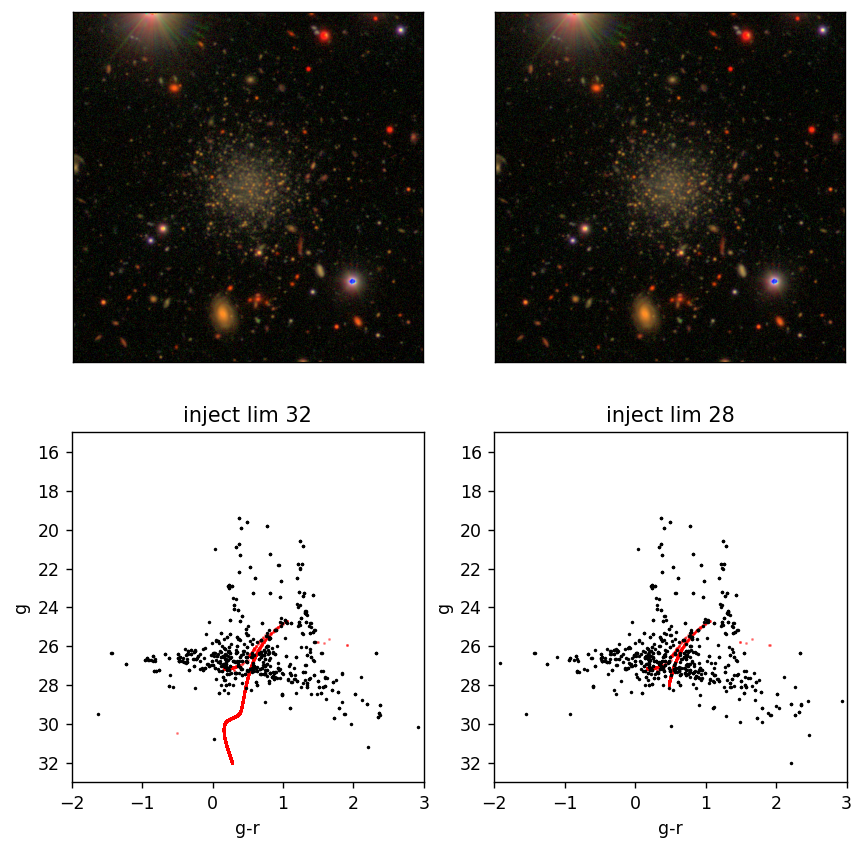

In [11]:
fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=125)
make_one_plot(objects=gri_list(data_dict_32), 
              title="lim_32" + '1.png', 
              data=8, 
              Q=10, 
              stretch=0.5, 
              minimum=(0.0, 0.0, 0.0),
              ax=axs[0,0])

make_one_plot(objects=gri_list(data_dict_28), 
              title="lim_32" + '1.png', 
              data=8, 
              Q=10, 
              stretch=0.5, 
              minimum=(0.0, 0.0, 0.0),
              ax=axs[0,1])
ax=axs[1,0]
make_cmd(data_dict_32, ax)
ax.set_title("inject lim 32")
ax=axs[1,1]
make_cmd(data_dict_28, ax)
ax.set_title("inject lim 28")